# <center> <u> Is Taylor's Law a sampling artifact? </u> </center>

**Reviewer 1** expressed concern that the observation of Taylor's Law may not reflect an underlying biological process, but rather a result of sampling from compositional data.

> The strong fit of Talyor's Law to the data leads me to question whether the model is largely just capturing a technical artifact of the data, such as its compositional nature. While this question has been addressed somewhat in past work, increased scrutiny in this focal work via robust simulations would help to convince myself and likely others that the Talyor's Law is capturing a biological phenomenon, in regards to strain-level diversity in the human gut

In short, our response is that while Taylor's Law could emerge as an artifact of compositional sampling, we would not observe the specific exponent ($\alpha = 1.63$) without some true underlying biological variability in the relative abundance of the populations.

![Taylor's Law observed in paper](TaylorsLawPaperFig.png)

**R1** requests simulations, which we perform below. The simulations, however, really just illustrate a more fundamental mathematical truth: namely, that were sampling noise the only source of variability of observed abundance between timepoints, we would expect to see a Taylor's Law exponent very close to 1. Essentially, this is due to the fact that if a strain's abundance were determined solely by sampling, it should approximately follow a Poisson distribution:  

$P(x_{i}=k) = \frac{\lambda^k e^{-\lambda} } {k!},$

where $\lambda$ would be the strain's average mean abundance. Because the mean of a Poisson distribution actually equals its variance (both are equal to $\lambda$, in this case), we should observe a Taylor's Law with $\alpha = 1$ (i.e.  $\sigma_{{x_i}}^2 \propto \langle x_i \rangle$, trivially).

First, I'll sketch out the simulations I performed, and then you can follow along with the code/potential figures.

### <u> Non-compositional data: constant strain abundances </u>

In the first simulation, each strain abundance is drawn from its own Poisson distribution, with composite rate parameter $S \times \lambda_i$. The scaling factor $S$ (which will later represent the total number of reads in the compositional simulations) does not affect the qualitative behavior of the simulations. However, this is a non-compositional simulation, as the total count summed across all strains is not specified *a prior*. 

**Result**: as expected, $\alpha \approx 1$.

### <u> Compositional data: constant sampling intensity, constant strain abundances </u>

Next, we assume that each strain does not change in abundance. Variations in abundance are therefore due solely to sampling.

We will need a few parameters for this process:

* $S$: total number of reads
* $N$: total number of species detected
* $\bar{\textbf{f}}$: vector of underlying true strain abundance distribution (rescaled lognormal)
* $T$: number of timepoints

The true underlying *abundances* of each strain (i.e. the total number of cells in the gut) are assumed to be effectively infinitely large, and therefore not affected by sampling. That is, with each of the $S$ total reads, we are effectively sampling the microbiome *with replacement*. Any variance in observed relative abundances between timepoints is therefore due solely to sampling noise. 

Though we are sampling with replacement relative to the broader community, our count data is *compositional*. We capture this compositionality by generating our observed data through multinomial sampling: 

$P(x_1, x_2, ... , x_N; N, f_1, f_2, ... , f_N) = \frac{S!}{x_1! x_2! ... x_N!}f_1^{x_1}f_2^{x_2}...f_N^{x_N}$

**Result**: as expected, $\alpha \approx 1$.

### <u> Variable sampling intensity, constant strain abundances </u>

Here, we allow the total read count $S$ to vary between samples. Variable sampling intensity is simulated under two regimes: Poisson sampling, and negative binomial sampling (overdispersed).

**Result**: again, as expected, $\alpha \approx 1$.

### <u> Constant sampling intensity, fluctuating strain abundances (Neutrality) </u>

In some sense, **R1**'s concerns are difficult to fully address, because even assuming that sampling noise is the only factor affecting fluctuations in observed relative abundances assumes something about the underlying biology of the strains. In fact, such a model actually includes an extremely strong and definitely incorrect assumption about strain dynamics - namely, that strains are totally static in their true abundances. However, other ecological models can also produce power-law scaling between means and variances in abundance. 

To simulate neutral ecological dynamics, I perform a modified version of a Wright-Fisher process, in which the next generation community is drawn randomly from the current generation by multinomial sampling:

$P(x_{1}^{(t)}, x_{2}^{(t)}, ... , x_{N}^{(t)}; N_e, f_{1}^{(t-1)}, f_{2}^{(t-1)}, ... , f_{N}^{(t-1)}) = \frac{N_e!}{x_{1}^{(t)}! x_{2}^{(t)}! ... x_{N}^{(t)}!}({f_1^{(t-1)}})^{x_{1}^{(t)}}({f_2^{(t-1)}})^{x_{2}^{(t)}}...({f_N^{(t-1)}})^{x_{N}^{(t)}} $

where,

$f_i^{(j)} = \frac{x_{1}^{(j)}}{\sum_{i=1}^N x_{i}^{(j)}}.$

**Result**: Depending on the parameterization, we observe $1 < \alpha < 2$, again as expected. With these neutral ecological simulations, we see that Taylor's Law is not evidence of one ecological model or another, nor even is the exponent proof of one ecological model or another. We are not arguing that Taylor's Law $\Rightarrow$ the SLM. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns

In [2]:
def return_TL_exp(meanbar,varbar):
    
    model = np.polyfit(np.log(meanbar), np.log(varbar),1)
    m,B = model
    x = np.linspace(min(np.log(meanbar)),max(np.log(meanbar)),1000,endpoint=True)
    y_bf = m*x + B
    beta = np.exp(B)
    
    return x,y_bf,m

In [3]:
def lognorm_initcom(N,sigma,thresh=1e-5):
    
    Xbar_0 = np.random.lognormal(mean=1/N,sigma=sigma,size=N)
    fbar_0 = Xbar_0/Xbar_0.sum()
    
    all_pass = False
    while not all_pass:
        num_pass = 1*(fbar_0 > thresh).sum()
        if num_pass < len(fbar_0):
            fbar_0 = fbar_0[fbar_0 > thresh]
            fbar_0 = fbar_0/fbar_0.sum()
        else:
            all_pass = True
        
    return fbar_0

In [44]:
def plot_TL(df,**kwargs):
    
    if not kwargs:
        fig,ax = plt.subplots(figsize=(8,6))
    
    else:
        fig,ax = kwargs["fig"],kwargs["ax"]
        
    ax.grid(color='k', linestyle='--', linewidth=.2,alpha=.6)
    ax.set_facecolor("#DAEBFE")
    ax.set_xlabel(r"$\langle x_i \rangle$",size=15)
    ax.set_ylabel(r"$\sigma_{x_i}^2$",size=15)
    
    meanbar = df.T.mean().values
    varbar = df.T.var().values

    x,y_bf,m = return_TL_exp(meanbar,varbar)
    
    ax.scatter(meanbar,varbar,s=70,zorder=100)
    ax.loglog(np.exp(x),np.exp(y_bf),color='black',label=fr"Taylor's Law, $ \sigma_{{x_i}}^2 \propto \langle x_i \rangle ^ { {np.around(m,2)} } $",
           zorder=1,linewidth=4)
                                                                                                                              
    ax_legend = ax.legend(loc='lower right',prop={'size': 20},edgecolor="black",framealpha=1)
    
    return fig

In [38]:
def sample_relative_abundances(S,fbar,T=1):
    
    Xhat = np.random.multinomial(S, fbar,size=T)
    fhat = Xhat/Xhat.sum()
    
    return fhat

In [39]:
S = 1e6
N = 40
T = 50

## dispersion parameter of SAD
sigma = 3

### <u> Poisson sampling </u>

In [40]:
lambda_bar = S*lognorm_initcom(N,sigma)

fhat = []
for _ in range(T):
    Xhat = (lambda x:np.random.poisson(x))(lambda_bar)
    fhat.append(Xhat/Xhat.sum())


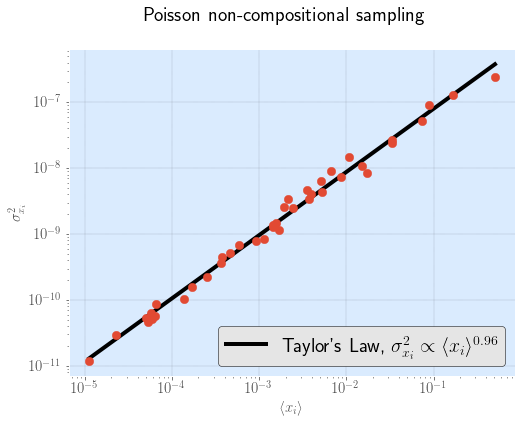

In [47]:
df = pd.DataFrame(fhat).T
df = df.loc[~(df==0).all(axis=1)]

fig = plot_TL(df)
fig.suptitle("Poisson non-compositional sampling",size=20);

### <u> Constant sampling intensity, constant strain abundances </u>

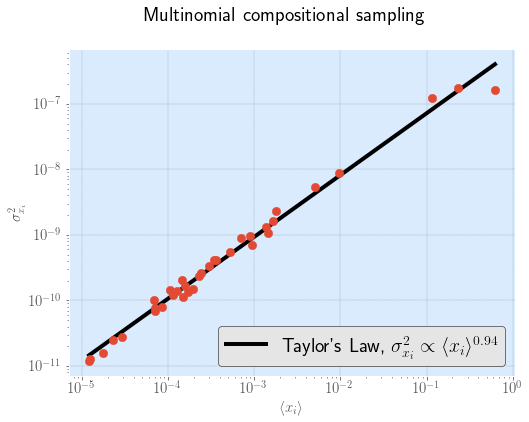

In [48]:
fbar = lognorm_initcom(N,sigma)

fhat = []
for _ in range(T):
    fhat.append(sample_relative_abundances(S,fbar)[0])

df = pd.DataFrame(fhat).T
df = df.loc[~(df==0).all(axis=1)]

fig = plot_TL(df)
fig.suptitle("Multinomial compositional sampling",size=20);

**Conclusions**: Taylor's Law holds w/ exponent $\approx 1$. As seen below, plotting a histogram of $\alpha$ values shows that $\alpha$ actually tends to be slightly less than 1, which is almost surely due to binomial variance going as $f_i(1-f_i)$ leading to variance getting proportionally smaller as $f_i \rightarrow 1$ (i.e. as the quadratic term becomes non-negligible). 

In [10]:
m_list = []
for _ in range(10000):    
    fhat = []
    for _ in range(T):
        fhat.append(sample_relative_abundances(S,fbar)[0])

    df = pd.DataFrame(fhat).T
    df = df.loc[~(df==0).all(axis=1)]
    
    meanbar = df.T.mean().values
    varbar = df.T.var().values

    x,y_bf,m = return_TL_exp(meanbar,varbar)
    m_list.append(m)

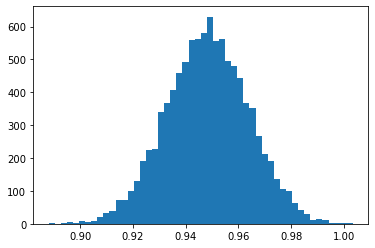

In [11]:
plt.hist(m_list,bins=50);

### <u> Variable sampling intensity, constant strain abundances </u>

Here, we allow sampling intensity to vary between samples. 

In the simplest model, the variability in sampling intensity is Poisson:

In [12]:
S_i = np.random.poisson(S,size=T)

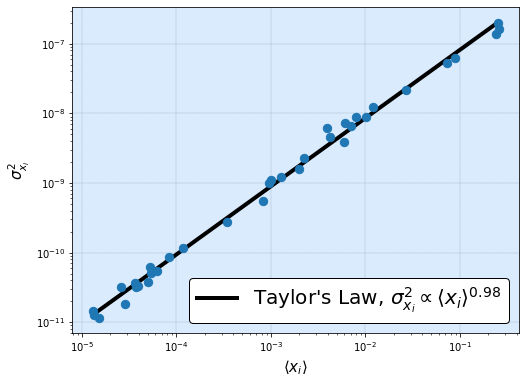

In [13]:
fbar = lognorm_initcom(N,sigma)

fhat = []
for s_i in S_i:
    fhat.append(sample_relative_abundances(s_i,fbar)[0])
    
fhat = np.array(fhat)
df = pd.DataFrame(fhat).T
df = df.loc[~(df==0).all(axis=1)]

plot_TL(df)

**Conclusions**: Poisson variable sampling intensity has negligible effect on Taylor's Law. Exponent still approximately 1. 


In a more complex model, the variability in sampling intensity is negative binomial, and can accomodate overdispersion (with parameter $d$) relative to Poisson:

In [14]:
d = .001
S_o = d/(1-d)*S
S_i = np.random.negative_binomial(S_o,d,size=T)

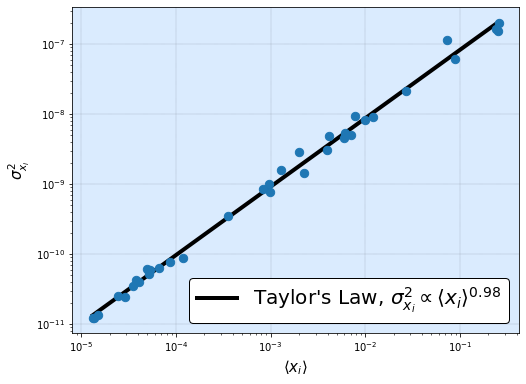

In [15]:
Xbar = lognorm_initcom(N,sigma)

fhat = []
for s_i in S_i:
    fhat.append(sample_relative_abundances(s_i,fbar)[0])
    
fhat = np.array(fhat)
df = pd.DataFrame(fhat).T
df = df.loc[~(df==0).all(axis=1)]

plot_TL(df)

**Conclusions**: Negative binomial sampling intensity has negligible effect on Taylor's Law, exponent still approximately 1. 


### <u> Constant sampling intensity, fluctuating strain abundances (Neutrality) </u>

Here, the underlying strain abundances are allowed to fluctuate through time according to a neutral model of community dynamics with no migration.

My first stab at this neutral simulation is just multinomial sampling of previous community state with parameter $N_e$ controlling the speed of the random walk. Essentially, this is Wright-Fisher but with many species, instead of two alleles. 

First, I plot the true abundance tractories obtained under a run of this model ($N_e = 10^3$)

<AxesSubplot:xlabel='Time', ylabel='True relative abundance'>

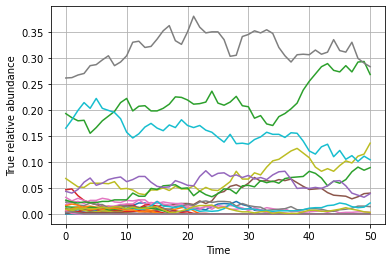

In [16]:
N_e = 1e3

fbar_0 = lognorm_initcom(N,sigma=2)

fbar_list = [fbar_0]
for _ in range(T):
    fbar_list.append(sample_relative_abundances(N_e,fbar_list[-1])[0])

df_fbar = pd.DataFrame(fbar_list)
df_fbar = df_fbar/df_fbar.T.sum()
df_fbar.plot(legend=None,xlabel="Time",ylabel="True relative abundance",grid=True)

Here is the Taylor's Law plot associated with these strain abundance trajectories:

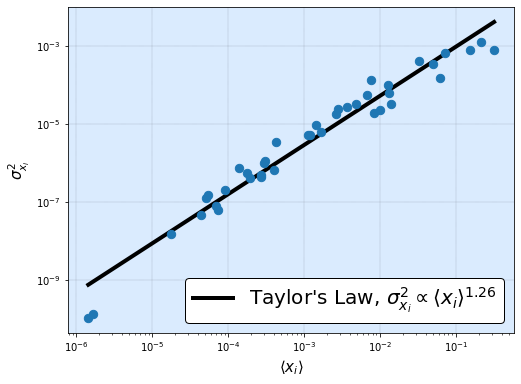

In [17]:
fhat_list = []
for i in range(T):
    fhat_list.append(sample_relative_abundances(S,fbar_list[i])[0])
    
fhat_list = np.array(fhat_list)
df = pd.DataFrame(fhat_list).T
df = df.loc[~(df==0).all(axis=1)]

plot_TL(df)

**Conclusions**: Still see Taylor's Law, and exponent tends to exceed 1. 

To consider the possibility that $\alpha > 1$ only as a result of extinctions, below I condition on the strain having survived throughout the timecourse:

<AxesSubplot:xlabel='Time', ylabel='True relative abundance'>

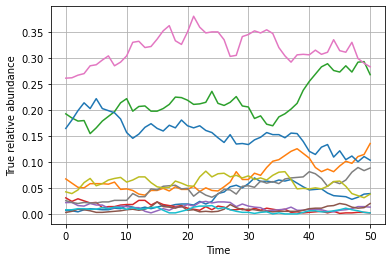

In [18]:
df_fbar = pd.DataFrame(fbar_list).T
df_fbar = df_fbar.loc[~(df_fbar==0).any(axis=1)]

df_fbar.T.plot(legend=None,xlabel="Time",ylabel="True relative abundance",grid=True)


Doing so, we still see $\alpha > 1$:

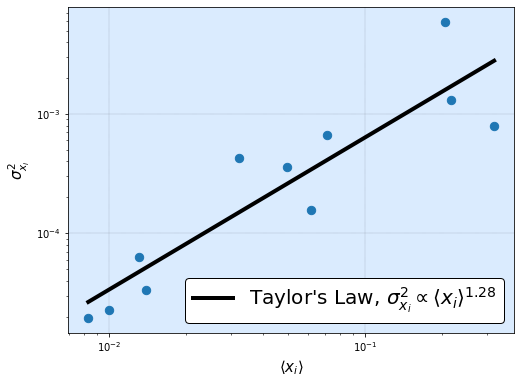

In [19]:
fhat_list = []
for i in range(T):
    fhat_list.append(sample_relative_abundances(S,df_fbar[i])[0])
    
fhat_list = np.array(fhat_list)
df = pd.DataFrame(fhat_list).T
df = df.loc[~(df==0).all(axis=1)]

plot_TL(df)

**Conclusion**: Neutral simulations can produce $\alpha$ that is different from what is expected under sampling noise.

### <u> Comparison with real data </u>

In [20]:
import config
import plot_cluster_utils as pcu

In [21]:
def sigma_2_xi(Ns,ns_i):
   # Ns = count_reads.sum()
   # ns_i = count_reads.loc[species]
    #return np.var(ns_i/Ns)
    return(np.mean((ns_i*(ns_i - 1)/(Ns*(Ns-1)))) - np.mean(ns_i/Ns)**2)

In [54]:
import warnings
warnings.filterwarnings("ignore")

means = []
var = []
all_strain_freqs = {}
color_list = []
for h in ["am","an","ao","ae"]:
    count_reads = pd.read_csv(f"{config.data_directory}species/count_reads.txt.bz2",sep="\t",index_col=0)
    rel_ab = pd.read_csv(f"{config.data_directory}species/relative_abundance.txt.bz2",sep="\t",index_col=0)
    psamps = config.Poyet_samples[h]
    sorted_species = pd.read_pickle(f"{config.metadata_directory}Poyet_species_host.pkl")
    sorted_species = sorted_species[h]
    
    Ns = count_reads.sum()

    for i in range(len(sorted_species)):
     
        try:
            strain_total_freqs = pcu.get_strain_total_freqs(sorted_species[i],h)
            for strain in strain_total_freqs.columns[:-2]:
                means.append(np.mean(strain_total_freqs[strain]))
                #print(np.mean(strain_total_freqs[strain]))
                ns_i = strain_total_freqs[strain]*Ns
                var.append(sigma_2_xi(Ns,ns_i))
                all_strain_freqs[(h,species,strain)] = strain_total_freqs[strain]
        except:
            pass         

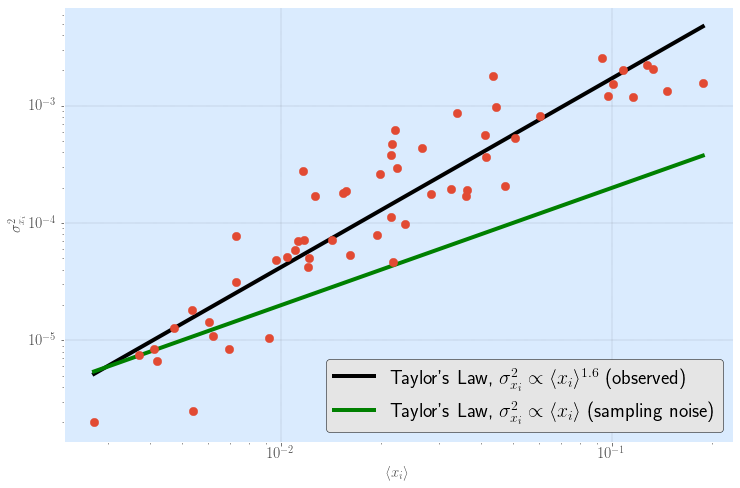

In [55]:
fig,ax = plt.subplots(figsize=(12,8))
ax.grid(color='k', linestyle='--', linewidth=.2,alpha=.6)
ax.set_facecolor("#DAEBFE")
ax.set_xlabel(r"$\langle x_i \rangle$",size=15)
ax.set_ylabel(r"$\sigma_{x_i}^2$",size=15)
    
x,y_bf,m = return_TL_exp(means,var)
    
ax.scatter(means,var,s=70,zorder=100)
ax.loglog(np.exp(x),np.exp(y_bf),color='black',label=fr"Taylor's Law, $ \sigma_{{x_i}}^2 \propto \langle x_i \rangle ^ { {np.around(m,1)} } $ (observed)",
           zorder=1,linewidth=4)

ax.loglog(np.exp(x),np.exp(x)*.002,color='green',label=fr"Taylor's Law, $ \sigma_{{x_i}}^2 \propto \langle x_i \rangle$ (sampling noise) ",
           zorder=1,linewidth=4)

ax_legend = ax.legend(loc='lower right',prop={'size': 20},edgecolor="black",framealpha=1)  


**Conclusions**: The real data quite obviously could not be produced by sampling noise alone, and there must be some underlying biological variability in strain abundances. There are many ecological models that could produce $\alpha$ values in the range we actually observe, and our purpose is not to argue that our observation is proof of any of them. We can, for instance, reject neutrality by other means. It is important to distinguish between what the exponent of Taylor's Law tells us (there is more than just sampling noise, compositional or otherwise, driving fluctuations in strain abundance) and what it isn't telling us (that any specific ecological model holds). 